## Outline

1. L2 norm and loading datasets
2. Modifying our FF Class
3. Use more complex models to reduce bias
4. Demonstrate overfitting for very large models
5. Use L2 regularisation for preventing overfitting
6. Use noise on training data for preventing overfitting
7. Exercises

## Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

from numpy.linalg import norm#import linear algebra of l2 norm
#http://mathworld.wolfram.com/L2-Norm.html

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [0]:
np.random.seed(0)

## Generate data

In [0]:
iris=load_iris()
data = iris.data[:, :2]  # take only the first two features
labels = iris.target
#https://scikit-learn.org/stable/datasets/index.html

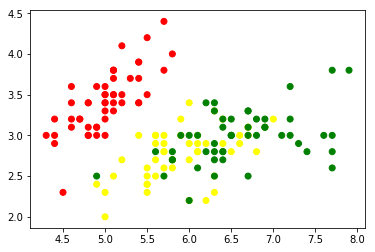

In [20]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [21]:
print("Data shape",data.shape)
print("Labels shape",labels.shape)

Data shape (150, 2)
Labels shape (150,)


## Multi class classification

In [22]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0,test_size=0.2)
print(X_train.shape, X_val.shape, labels.shape)

(120, 2) (30, 2) (150,)


In [23]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(120, 3) (30, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

## FF Class

In [0]:
class FFNetwork:
  
  def __init__(self, num_hidden=2, init_method = 'xavier', activation_function = 'sigmoid', leaky_slope = 0.1):
        
    self.params={}
    self.num_layers=2
    self.layer_sizes = [2, num_hidden, 3]
    self.activation_function = activation_function
    self.leaky_slope = leaky_slope
    np.random.seed(0)
    
    if init_method == "random":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "he":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "xavier":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
    
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X)
      
  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "relu":
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d
    
  def get_accuracy(self):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    return accuracy_train,accuracy_val
    
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 2) -> (N, 2)
    self.H2 = self.softmax(self.A2) # (N, 2)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD",l2_norm=False, lambda_val=0.8, display_loss=False, eta=1):
    train_accuracies={}
    val_accuracies={}
    if display_loss:
      loss = []
      weight_mag = []
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      self.grad(X, Y)
      for i in range(1,self.num_layers+1):
        if l2_norm:
          self.params["W"+str(i)] -= (eta * lambda_val)/m * self.params["W"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
        else:
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      train_accuracy,val_accuracy=self.get_accuracy()
      train_accuracies[num_epoch]=train_accuracy
      val_accuracies[num_epoch]=val_accuracy
      if display_loss:
        Y_pred = self.predict(X)
        loss.append(log_loss(np.argmax(Y, axis=1), Y_pred))
        weight_mag.append((norm(self.params["W1"]) + norm(self.params["W2"]) + norm(self.params["B1"]) + norm(self.params["B2"]))/18)
        
    plt.plot(train_accuracies.values(),label="Train accuracy")
    plt.plot(val_accuracies.values(),label="Validation accuracy")
    plt.plot(np.ones((epochs, 1))*0.9)
    plt.plot(np.ones((epochs, 1))*0.33)#random model accuracy
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    if display_loss:
      fig, ax1 = plt.subplots()
      color = 'tab:red'
      ax1.set_xlabel('epochs')
      ax1.set_ylabel('Log Loss', color=color)
      ax1.plot(loss, '-o', color=color)
      ax1.tick_params(axis='y', labelcolor=color)
      ax2 = ax1.twinx()  # two y axis in same plot
      color = 'tab:blue'
      ax2.set_ylabel('Weight Magnitude', color=color)  # we already handled the x-label with ax1
      ax2.plot(weight_mag, '-*', color=color)
      ax2.tick_params(axis='y', labelcolor=color)
      fig.tight_layout()  
      plt.show()

  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()                               

In [0]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

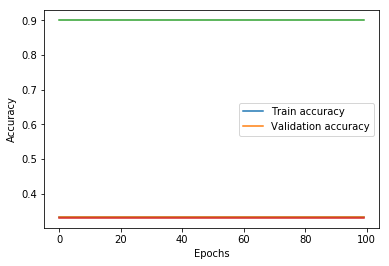

Training accuracy 0.3333
Validation accuracy 0.3333


In [31]:
model = FFNetwork(num_hidden=1)
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

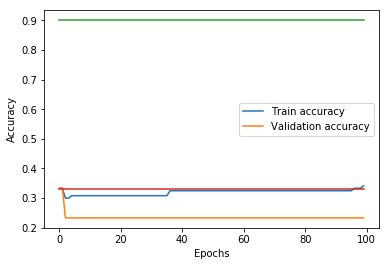

Training accuracy 0.3417
Validation accuracy 0.2333


In [32]:
model = FFNetwork(num_hidden=2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, display_loss=False)
print_accuracy()

Bias is the distance from the top green line, more the distance, more the bias. in this case model is having large bias.

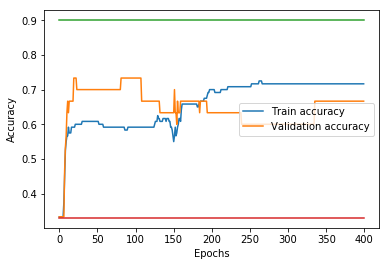

Training accuracy 0.7167
Validation accuracy 0.6667


In [0]:
model = FFNetwork(num_hidden=4)
model.fit(X_train, y_OH_train, epochs=400, eta=0.25, display_loss=False)
print_accuracy()

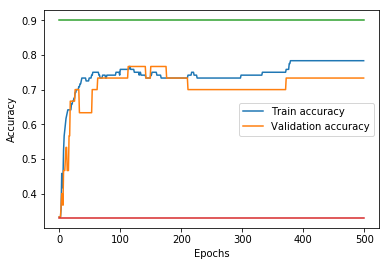

Training accuracy 0.7833
Validation accuracy 0.7333


In [0]:
model = FFNetwork(num_hidden=8)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=False)
print_accuracy()

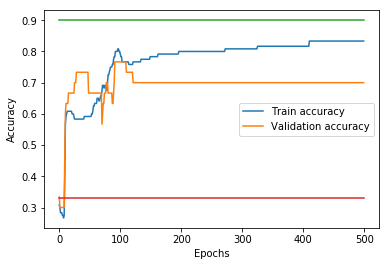

Training accuracy 0.8333
Validation accuracy 0.7


In [0]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=False)
print_accuracy()

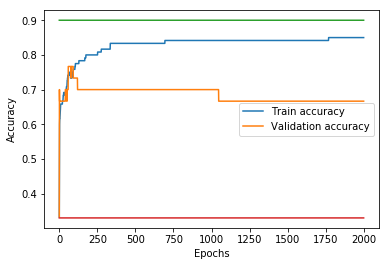

Training accuracy 0.85
Validation accuracy 0.6667


In [0]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
print_accuracy()

here validation accuracy decrease although training accuracy increase. so here come the L2 norm play...bias reducing but variance increasing

## Add L2 Regularization

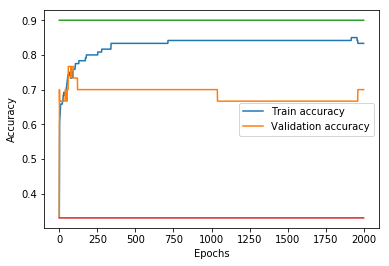

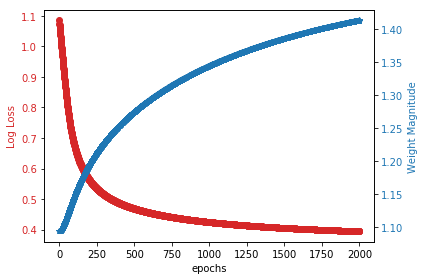

Training accuracy 0.8333
Validation accuracy 0.7


In [0]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=0.1, display_loss=True)
print_accuracy()

we will put some cap on increasing training loss by increasing lemda value.

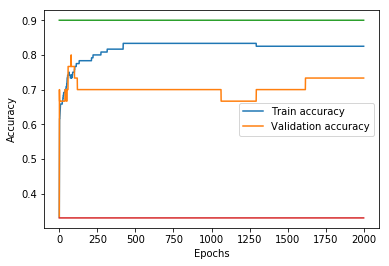

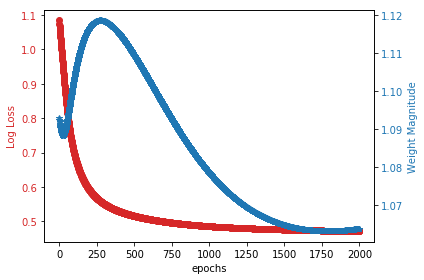

Training accuracy 0.825
Validation accuracy 0.7333


In [0]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=1, display_loss=True)
print_accuracy()

blue line come down slightly (bias decrease)but orange line slightly increase

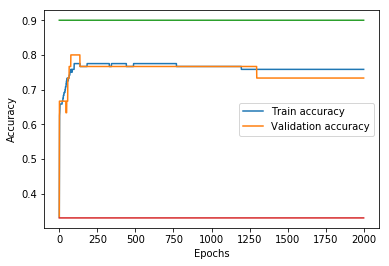

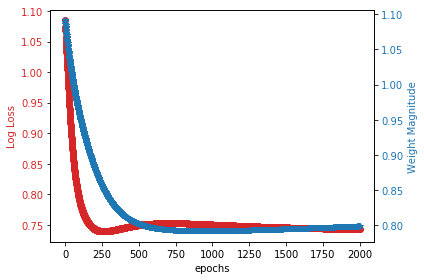

Training accuracy 0.7583
Validation accuracy 0.7333


In [0]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=5, display_loss=True)
print_accuracy()

variance narrow down to zero but bias increase 

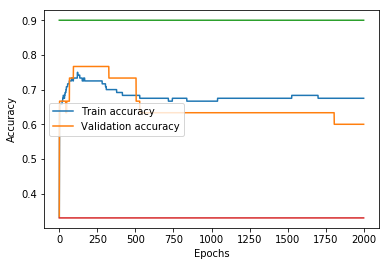

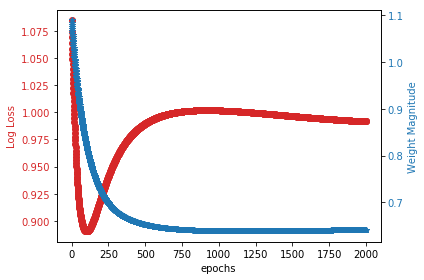

Training accuracy 0.675
Validation accuracy 0.6


In [0]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=10, display_loss=True)
print_accuracy()

overregularization


## Add noise to training data set

adding noise is nothing but shifting the input dataset into some fraction value. in case of refgression, we also add noise in output.

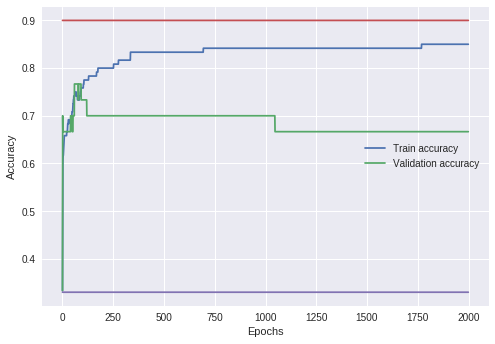

Training accuracy 0.85
Validation accuracy 0.6667


In [0]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
print_accuracy()

0.01


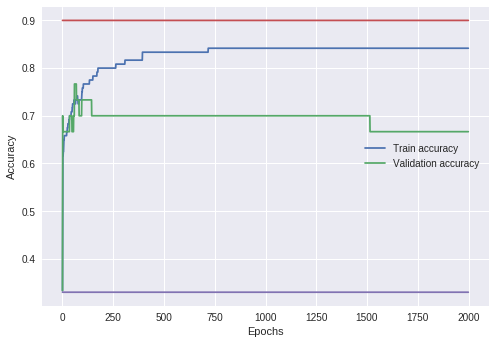

Training accuracy 0.8417
Validation accuracy 0.6667
0.05


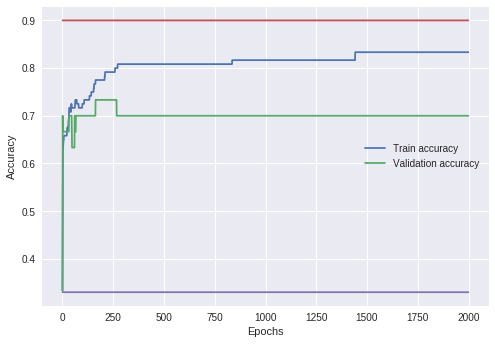

Training accuracy 0.8333
Validation accuracy 0.7
0.1


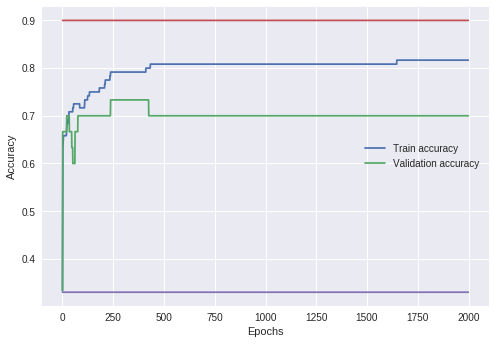

Training accuracy 0.8167
Validation accuracy 0.7
0.15


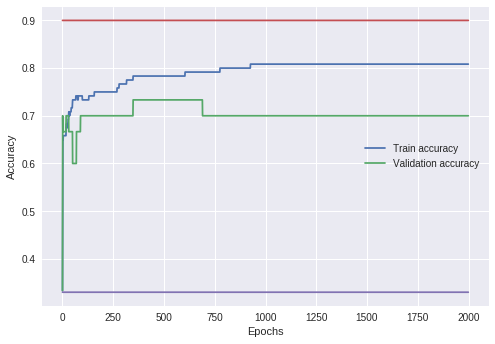

Training accuracy 0.8083
Validation accuracy 0.7
0.18


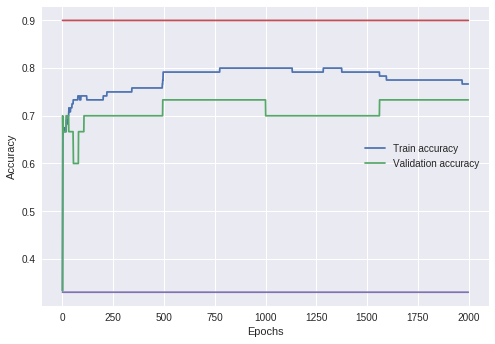

Training accuracy 0.7667
Validation accuracy 0.7333
0.2


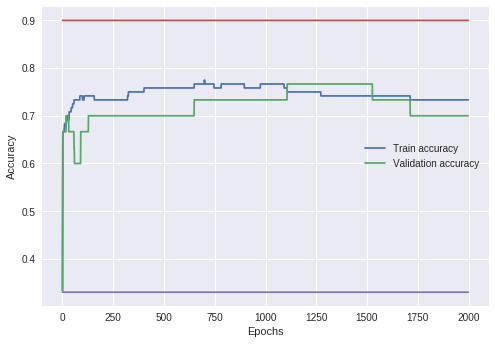

Training accuracy 0.7333
Validation accuracy 0.7


In [0]:
for noise_fraction in [0.01, 0.05, 0.1, 0.15, 0.18, 0.2]:
  print(noise_fraction)
  X_train_noisy = X_train * (1 - noise_fraction*np.random.randn(X_train.shape[0], X_train.shape[1]))
  model = FFNetwork(num_hidden=64)
  model.fit(X_train_noisy, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
  print_accuracy()

## Early stopping

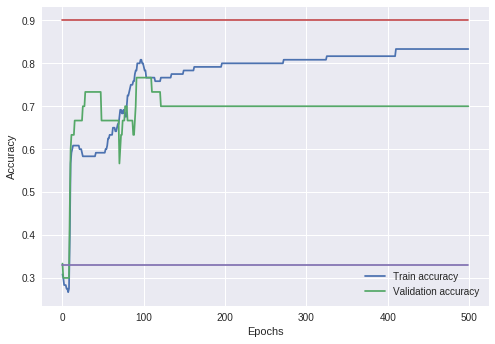

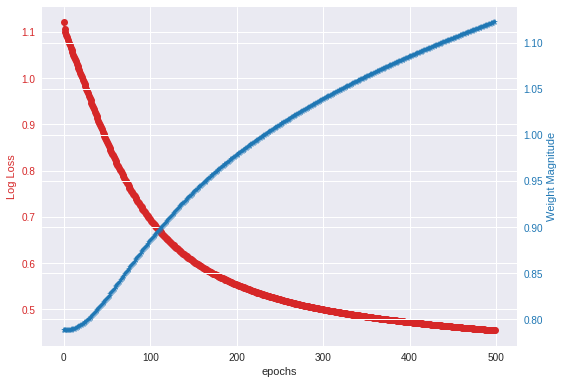

Training accuracy 0.8333
Validation accuracy 0.7


In [0]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=True)
print_accuracy()

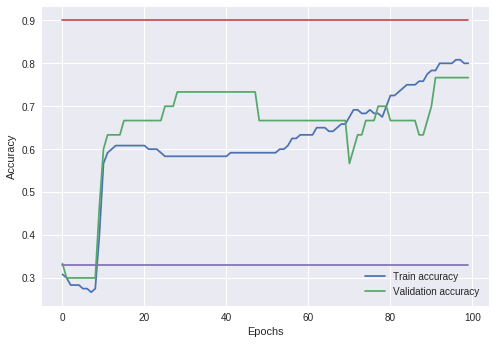

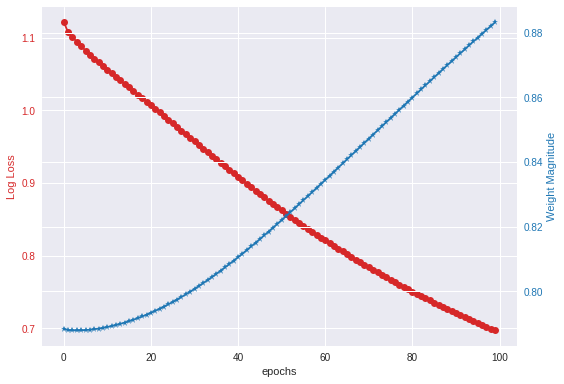

Training accuracy 0.8
Validation accuracy 0.7667


In [0]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=100, eta=0.2, display_loss=True)
print_accuracy()

## Exercises

* Repeat the above with at least one other activation function / initialisation method pair
* For the iris data-set, repeat the above with the entire data-set, i.e. not with just two inputs - modify the class to support that
* Repeat the above with at least one other data-set (eg. from sklearn.datasets) 
